# Setup

## 1. Clone dlfb library

In [ ]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 2.08 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


## 2. Install Dependencies

In [ ]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,proteins,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.21 x86_64-unknown-linux-gnu
Resolved 141 packages in 2.67s
Using Python 3.12.12 environment at: /usr
Resolved 141 packages in 454ms
Prepared 63 packages in 15.49s
Uninstalled 44 packages in 979ms
Installed 64 packages in 316ms
 - absl-py==1.4.0
 + absl-py==2.3.1
 + adjusttext==1.3.0
 + biopython==1.85
 - certifi==2025.11.12
 + certifi==2022.12.7
 - charset-normalizer==3.4.4
 + charset-normalizer==2.1.1
 - click==8.3.1
 + click==8.1.8
 - datasets==4.0.0
 + datasets==2.19.1
 + dlfb==0.1.1 (from file:///content/dlfb-clone)
 - flatbuffers==25.9.23
 + flatbuffers==25.12.19
 - flax==0.10.7
 + flax==0.10.4
 - fsspec==2025.3.0
 + fsspec==2024.3.1
 - google-auth==2.43.0
 + google-auth==2.45.0
 - google-cloud-storage==3.7.0
 + google-cloud-storage==3.0.0
 - google-crc32c==1.7.1
 + google-crc32c==1.8.0
 - humanize==4.14.0
 + humanize==4.15.0
 - idna==3.11
 + idna==3.4
 + ipinfo==5.1.1
 - jax==0.7.2
 + jax==0.5.1
 + jax-cuda12-pjrt==0.5.1
 + jax-cuda12-plugin==0.5.1
 - jaxlib==0

## 3. Provide the datasets

In [ ]:
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter dna

Files Downloaded: 100% 264/264 [00:03<00:00, 68.63file/s]


## 4. Import dlfb package

In [ ]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


In [ ]:
!pip install --upgrade numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.30.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.4.0 which is incompatible.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
gradio 5.50.0 requires typer<

In [ ]:
from dlfb.utils.context import assets
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import flax.linen as nn
import numpy as np
import pandas as pd
import tensorflow as tf

# Building a simple prototype

The modeling task we’ll tackle in this notebook is a binary classification problem:

given a 200-base DNA sequence, can we predict whether it binds to a specific TF called CTCF?

## Preparing the Data

In [ ]:
from dlfb.utils.context import assets

train_df = pd.read_csv(assets("dna/datasets/CTCF_train_sequences.csv"))
print(train_df)

                                                sequence  label  \
0      TACCACATGAGTTCTCTTTCAGTTTGCTATGGAAGACACAAAAACC...      1   
1      CATCAACACTCGTGCGACGCCCTCGCATTTTCATTAATGATGGCCT...      0   
2      GCACACAGCGCAGGAACCTGGCACTGGAGAAGCCACCCAGGCTGTG...      1   
3      GCCAGCCGAAGCAGAGAGCAGTGCACATGCGTGCAGCTACCAGCAT...      1   
4      GTCCCGTCCCTTTTCGTGCCTCTGCCCCCACAGCTGCTGCAGTCTG...      1   
...                                                  ...    ...   
61078  AATATGACCCTGCTGGCCTTAGGCCTACTCCTGTACCACAAGTGCC...      0   
61079  GATAAACCAAGGTCGTAAGTTCAGGCTCCGCCTCCCCGCAGGGCCT...      1   
61080  CCTCCCTCCCATCCCCCACACAGTTTAATGTCTAGAAGGTTGCCTG...      1   
61081  CAGGAATGCACCGGAAGTCCGCCTCCCGGGACCCGCCGCCGGTCCC...      0   
61082  AAAACAGAAACTGAAACTTCAAACACAGAGACAGAAAAAAAAAAAA...      0   

      transcription_factor subset  
0                     CTCF  train  
1                     CTCF  train  
2                     CTCF  train  
3                     CTCF  train  
4              

In [ ]:
train_df["label"].value_counts()

,count
label,
1,30545
0,30538


To use the DNA sequences numerically, we need to convert them into one-hot format.

In [ ]:
def dna_to_one_hot(dna_sequence: str) -> np.ndarray:
  """Convert DNA into a one-hot encoded format with channel ordering ACGT."""
  base_to_one_hot = {
    "A": (1, 0, 0, 0),
    "C": (0, 1, 0, 0),
    "G": (0, 0, 1, 0),
    "T": (0, 0, 0, 1),
    "N": (1, 1, 1, 1),  # N represents any unknown or ambiguous base.
  }
  one_hot_encoded = np.array([base_to_one_hot[base] for base in dna_sequence])
  return one_hot_encoded

In [ ]:
dna_to_one_hot("AAACGT")

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [ ]:
x_train = np.array([dna_to_one_hot(seq) for seq in train_df["sequence"]])

In [ ]:
x_train.shape

(61083, 200, 4)

In [ ]:
y_train = train_df["label"].values[:, None]

In [ ]:
y_train.shape

(61083, 1)

The dataset loading code for this problem is fairly straightforward, but we can wrap it into a convenient function called `load_dataset` for cleaner use:

In [ ]:
def load_dataset(sequence_db) -> dict[str, np.ndarray]:
  """Load sequences and labels from a CSV into numpy arrays."""
  df = pd.read_csv(sequence_db)
  return {
    "labels": df["label"].to_numpy()[:, None],
    "sequences": np.array([dna_to_one_hot(seq) for seq in df["sequence"]]),
  }

### Converting data to a TensorFlow dataset

This format makes it easy to efficiently iterate over batches during model training,

In [ ]:
def convert_to_tfds(
  dataset, batch_size: int | None = None, is_training: bool = False
):
  """Convert DNA sequences and labels to a TensorFlow dataset."""
  ds = tf.data.Dataset.from_tensor_slices(dataset)
  if is_training:
    ds = ds.shuffle(buffer_size=len(dataset["sequences"]))
    ds = ds.repeat()
  batch_size = batch_size or len(dataset["labels"])
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
batch_size = 32

train_ds = convert_to_tfds(
  load_dataset(assets("dna/datasets/CTCF_train_sequences.csv")),
  batch_size=batch_size,
  is_training=True,
)

Let’s sanity-check by pulling one batch from the dataset and inspecting its shape and contents

In [ ]:
batch = next(train_ds.as_numpy_iterator())
print(f'Batch sequence shape: {batch["sequences"].shape}')
print(f'Batch sequence instances: {batch["sequences"][:3,:3,]}...')
print(f'Batch labels shape: {batch["labels"].shape}')
print(f'Batch labels instances: {batch["labels"][:3,]}...')

Batch sequence shape: (32, 200, 4)
Batch sequence instances: [[[0 1 0 0]
  [0 1 0 0]
  [1 0 0 0]]

 [[1 0 0 0]
  [1 0 0 0]
  [0 1 0 0]]

 [[1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]...
Batch labels shape: (32, 1)
Batch labels instances: [[1]
 [0]
 [1]]...


For validation, since the dataset is smaller, we can structure it as one single big batch:

In [ ]:
valid_ds = load_dataset(assets("dna/datasets/CTCF_valid_sequences.csv"))

## Defining a Simple Convolutional Model

In [ ]:
class ConvModel(nn.Module):
  """Basic CNN model for binary sequence classification."""

  conv_filters: int = 64  # Number of filters for conv layers.
  kernel_size: tuple[int] = (10,)  # Kernel size for 1D conv layers.
  dense_units: int = 128  # Units in first dense fully-connected layer.

  @nn.compact
  def __call__(self, x):
    # First convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))


    # Second convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Flatten the values before passing them to the dense layers.
    x = x.reshape((x.shape[0], -1))

    # First dense layer.
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)

    # Second dense layer.
    x = nn.Dense(self.dense_units // 2)(x)
    x = nn.gelu(x)

    # Output layer (single unit for binary classification).
    return nn.Dense(1)(x)

### instantiate the model

In [ ]:
model = ConvModel()

### initialize model parameters

To initialize model parameters in JAX, we need to provide a dummy input tensor that matches the expected shape of the model’s input. Although we could use an actual batch from our dataset, it is common and simpler to use a tensor of ones with batch size 1 and the same shape as a single-encoded DNA sequence.

Importantly, the batch size used for this dummy input does not affect the model initialization—JAX initializes parameters based on the shape of an individual input sample (excluding the batch dimension). This means the model can later be trained or used for inference with any batch size.



In [ ]:
batch["sequences"].shape

(32, 200, 4)

`(batch_size, sequence_length, channels)`

Flattening

`(batch_size, sequence_length, channels)` => `(batch_size, flattened_features)`

In [ ]:
import jax
import jax.numpy as jnp

dummy_input = jnp.ones((1, *batch["sequences"][1,].shape))
print(dummy_input.shape)

# random key rng_init seeds any stochastic initialization, ensuring reproducibility.
rng_init = jax.random.PRNGKey(42)
variables = model.init(rng_init, dummy_input)
params = variables["params"]

(1, 200, 4)


Check the parameter keys (layer names)

In [ ]:
params.keys()

dict_keys(['Conv_0', 'Conv_1', 'Dense_0', 'Dense_1', 'Dense_2'])

Check each layer’s kernel shape

In [ ]:
for layer_name in params.keys():
  print(f'Layer {layer_name} param shape: {params[layer_name]["kernel"].shape}')

Layer Conv_0 param shape: (10, 4, 64)
Layer Conv_1 param shape: (10, 64, 64)
Layer Dense_0 param shape: (3200, 128)
Layer Dense_1 param shape: (128, 64)
Layer Dense_2 param shape: (64, 1)


`(kernel_size, input_channels, output_channels)`

`(input_features, output_units)`

## Making predictions with the model

predictions from the model using the randomly initialized parameters

In [ ]:
logits = model.apply({"params": params}, batch["sequences"])

# Apply sigmoid to convert logits to probabilities.
probs = nn.sigmoid(logits)

# Print just the first few predictions.
print(probs[0:5])

[[0.49570572]
 [0.4952158 ]
 [0.48525646]
 [0.5001588 ]
 [0.4840583 ]]


Since the model is untrained, predicted probabilities will be around around 0.5, reflecting pure guesswork from our randomly-parameterized model.

### Defining a loss function

binary cross-entropy loss function

In [ ]:
import optax

def calculate_loss(params, batch):
  """Make predictions on batch and compute binary cross entropy loss."""
  logits = model.apply({"params": params}, batch["sequences"])
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
  return loss

In [ ]:
calculate_loss(params, batch)

Array(0.6972181, dtype=float32)

### Defining the TrainState

To start training the model, we first need to define the optimizer.

In [ ]:
learning_rate = 0.001

tx = optax.adam(learning_rate)

we now have all the components to initialize the training state.

For this, we’ll use Flax’s `TrainState` `class`, which is a `container` that bundles all the important objects for training (the model, parameters, and optimizer)

In [ ]:
from flax.training.train_state import TrainState

state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

For convenience, let’s define a function to create the train state

In [ ]:
def create_train_state(model, rng, dummy_input, tx) -> TrainState:
  variables = model.init(rng, dummy_input)
  state = TrainState.create(
    apply_fn=model.apply, params=variables["params"], tx=tx
  )
  return state

In [ ]:
@jax.jit
def train_step(state, batch):
  """Run single training step to compute gradients and update model params."""
  grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
  loss, grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)
  return state, loss

In [ ]:
state, loss = train_step(state, batch)

If our setup is working well, the training loss should already be lower on this batch.

In [ ]:
calculate_loss(state.params, batch)

Array(0.6695653, dtype=float32)

### Training the Simple Model

In [ ]:
valid_ds

{'labels': array([[0],
        [0],
        [0],
        ...,
        [1],
        [0],
        [0]], shape=(8726, 1)),
 'sequences': array([[[0, 0, 1, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 1, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 1, 0, 0],
         [0, 0, 0, 1],
         ...,
         [0, 1, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 1, 0, 0],
         [0, 0, 0, 1],
         ...,
         [0, 0, 1, 0],
         [0, 1, 0, 0],
         [1, 0, 0, 0]],
 
        ...,
 
        [[0, 1, 0, 0],
         [0, 1, 0, 0],
         [0, 1, 0, 0],
         ...,
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0]],
 
        [[1, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 1, 0, 0],
         ...,
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 1, 0, 0]],
 
        [[1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
        

In [ ]:
train_ds

<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'sequences': TensorSpec(shape=(None, 200, 4), dtype=tf.int64, name=None)}>

In [ ]:
import tqdm

# Reinitialize the model state to ensure we start fresh each time cell is run.
rng_init = jax.random.PRNGKey(42)
state = create_train_state(model, rng_init, dummy_input, tx)

# Keep track of both the training and validation set losses.
train_losses, valid_losses = [], []
train_batches = train_ds.as_numpy_iterator()

# We use tqdm, which is a progress bar.
for step in tqdm.tqdm(range(500)):
  batch = next(train_batches)
  state, loss = train_step(state, batch)
  train_losses.append({"step": step, "loss": loss.item()})

  # Compute loss on the entire validation set occasionally (every 100 steps).
  if step % 100 == 0:
    valid_loss = calculate_loss(state.params, valid_ds)
    valid_losses.append({"step": step, "loss": valid_loss.item()})

losses = pd.concat(
  [
    pd.DataFrame(train_losses).assign(split="train"),
    pd.DataFrame(valid_losses).assign(split="valid"),
  ]
)

100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


In [ ]:
losses

,step,loss,split
0,0,0.694103,train
1,1,0.641732,train
2,2,0.693949,train
3,3,0.809460,train
4,4,0.692049,train
...,...,...,...
0,0,0.707296,valid
1,100,0.500903,valid
2,200,0.419024,valid
3,300,0.333652,valid


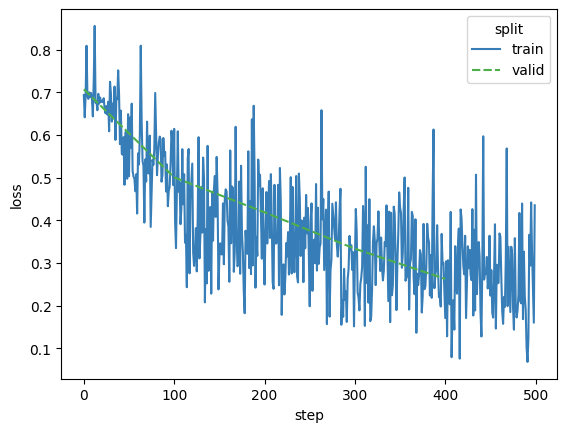

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

sns.lineplot(
  data=losses,
  x="step",
  y="loss",
  hue="split",
  style="split", # tells seaborn to draw different line styles (e.g. solid vs dashed, different markers)
  palette=DEFAULT_SPLIT_COLORS
);

# Conducting In Silico Mutagenesis

Before making all possible mutations, let’s first check the effect of making just a single mutation. We’ll start by identifying a DNA sequence in the validation set that binds the CTCF protein (i.e., has a label of `1`)

In [ ]:
# The first positive example of a sequence that binds the transcription factor.
first_positive_index = np.argmax(valid_ds["labels"].flatten() == 1)

original_sequence = valid_ds["sequences"][first_positive_index].copy()
print(f'This sequence has label: {valid_ds["labels"][first_positive_index]}')

This sequence has label: [1]


In [ ]:
original_sequence.shape

(200, 4)

In [ ]:
pred = nn.sigmoid(
  model.apply({"params": state.params}, original_sequence[None, :])
)
pred

Array([[0.98701745]], dtype=float32)

create a single mutation at position 100

In [ ]:
sequence = original_sequence.copy()
print(f"Original base at index 100: {sequence[100]}")

sequence[100] = np.array([0, 1, 0, 0])
print(f"Mutated base at index 100: {sequence[100]}")

Original base at index 100: [0 0 1 0]
Mutated base at index 100: [0 1 0 0]


In [ ]:
pred_with_mutation = nn.sigmoid(
  model.apply({"params": state.params}, sequence[None, :])
)
pred_with_mutation

Array([[0.96814436]], dtype=float32)

This shows that even a single-base change at a sensitive position can substantially impact the model’s output.

systematically mutate every position in the sequence

In [ ]:
def generate_all_mutations(sequence: np.ndarray) -> np.ndarray:
  """Generate all possible single base mutations of a one-hot DNA sequence."""
  mutated_sequences = []
  for i in range(sequence.shape[0]):
    # At each position, one the four 'mutations' is the original base (no-op).
    for j in range(4):
      mutated_sequence = sequence.copy()
      mutated_sequence[i] = np.zeros(4)
      mutated_sequence[i][j] = 1
      mutated_sequences.append(mutated_sequence)

  sequences = np.stack(mutated_sequences)
  return sequences


mutated_sequences = generate_all_mutations(sequence=original_sequence.copy())
print(f"Shape of mutated sequences: {mutated_sequences.shape}")

Shape of mutated sequences: (800, 200, 4)


In [ ]:
preds = nn.sigmoid(model.apply({"params": state.params}, mutated_sequences))

# Reshape to get the shape (sequence_length, dna_bases).
preds

Array([[0.98701745],
       [0.98706484],
       [0.9871718 ],
       [0.987394  ],
       [0.988301  ],
       [0.98701745],
       [0.98773694],
       [0.9880435 ],
       [0.9884354 ],
       [0.98701745],
       [0.987987  ],
       [0.9879533 ],
       [0.98646706],
       [0.98701745],
       [0.98801917],
       [0.9883731 ],
       [0.98790205],
       [0.98701745],
       [0.9877109 ],
       [0.9883083 ],
       [0.98701745],
       [0.9859467 ],
       [0.9881543 ],
       [0.98756146],
       [0.9867721 ],
       [0.9859492 ],
       [0.98701745],
       [0.9865891 ],
       [0.9870187 ],
       [0.9879242 ],
       [0.98701745],
       [0.9880613 ],
       [0.9885684 ],
       [0.9867619 ],
       [0.98701745],
       [0.9884503 ],
       [0.9881026 ],
       [0.9863738 ],
       [0.98634964],
       [0.98701745],
       [0.98701745],
       [0.98783535],
       [0.98447186],
       [0.988634  ],
       [0.9884517 ],
       [0.9869163 ],
       [0.98701745],
       [0.988

In [ ]:
preds.shape

(800, 1)

In [ ]:
preds = preds.reshape((200, 4))

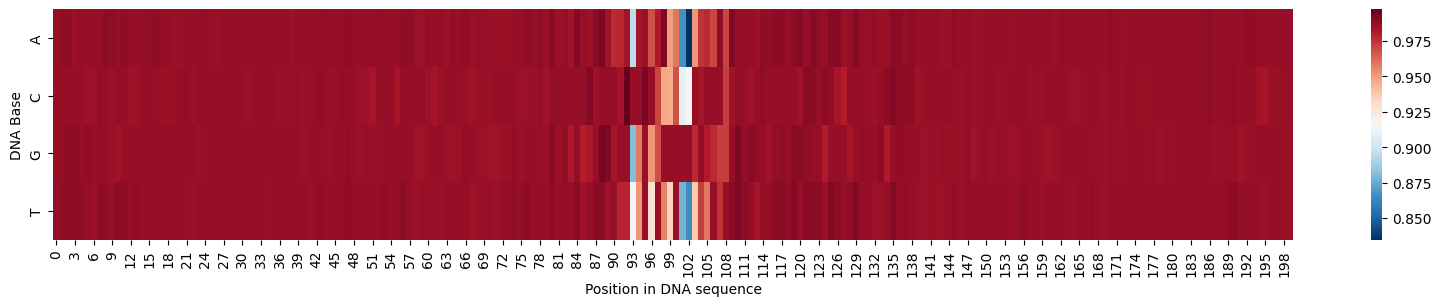

In [ ]:
plt.figure(figsize=(20, 3))
sns.heatmap(preds.T, cmap="RdBu_r", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base");

Most mutations don’t change the prediction much. The model predicts close to the original probability of CTCF binding for sequences containing most mutations.

A central region does appear to significantly affect the binding prediction.

But what we really care about is how much each mutation changes the prediction. Let’s subtract the original (unmutated) predicted probability and center the color map at zero

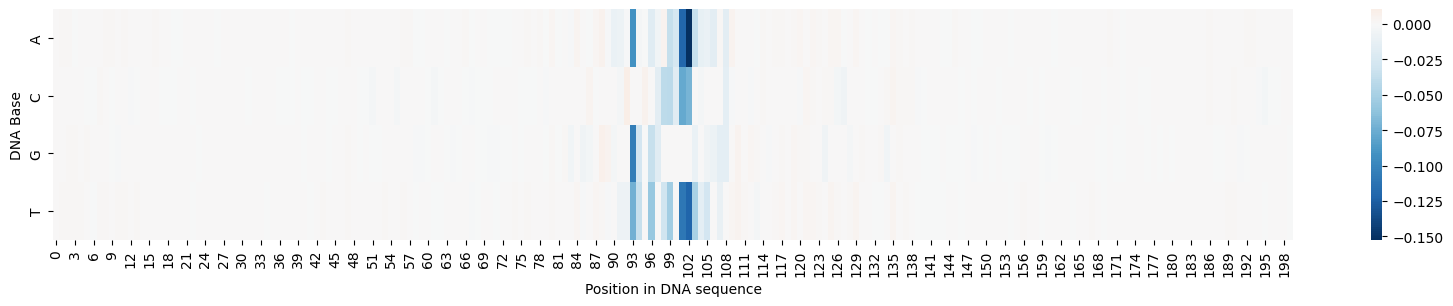

In [ ]:
baseline_pred = nn.sigmoid(
  model.apply({"params": state.params}, original_sequence[None, :])
)
deltas = preds - baseline_pred

plt.figure(figsize=(20, 3))
sns.heatmap(deltas.T, center=0, cmap="RdBu_r", yticklabels=["A", "C", "G", "T"])
plt.xlabel("Position in DNA sequence")
plt.ylabel("DNA Base");

Now the heatmap is clearer:

- Most positions are lighter, meaning their mutations have little effect.

- A few bases in the center are dark (decreased binding) or light (increased binding), showing meaningful influence.

In [ ]:
deltas.shape

(200, 4)

summarize the overall importance of each position in the DNA sequence by summing the absolute changes across all possible base mutations at each position.

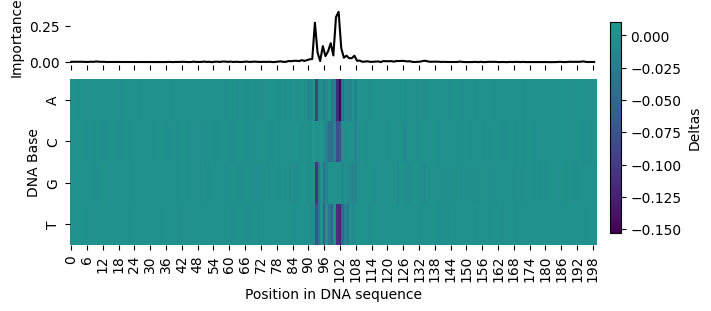

In [ ]:
from dlfb.dna.inspect import plot_binding_site

importance = np.sum(np.abs(deltas), axis=1)
plot_binding_site(
  panels={
    "tiles": {"label": "Deltas", "values": deltas},
    "line": {"label": "Importance", "values": importance},
  }
);

In this case, the largest increase comes from mutating the base at position 92 with G→C (3.11% increase), and the biggest decrease comes from mutating the base at position 102 with G→T (-20.24% decrease).

# Modeling Multiple Transcription Factors

The dataset includes binding labels for the following 10 transcription factors:

In [ ]:
transcription_factors = [
  "ARID3",
  "ATF2",
  "BACH1",
  "CTCF",
  "ELK1",
  "GABPA",
  "MAX",
  "REST",
  "SRF",
  "ZNF24",
]

There are two common strategies for tackling this problem:

- **Multitask learning:**
Train a single model to output one prediction per TF, potentially learning shared representations across tasks.
- **Single-task learning:**
Train separate binary classification models for each TF independently.

Given these factors, we’ll follow a single-task learning approach: train 10 individual binary classification models, one per TF.

## Defining a more complex model

Now that we’re training on 10 separate TF binding tasks, it’s a good opportunity to improve the `training stability` and `generalization` of our model.

We’ll retain the same core convolutional architecture from earlier, but introduce three standard deep learning techniques—
- batch normalization (after each convolutional layer)
  - Batch norm normalizes the activations across the batch
- dropout (after the dense (fully connected) layers)
  - Dropout randomly sets a portion of activations to zero during training
- learning rate scheduling

**Important notes:**

- Batch norm behaves differently during training and inference.
During training, it computes mean and variance from the current batch and updates running averages;
at inference time, it uses the learned averages.

  - In Flax, you control this behavior with the `is_training` flag using the `use_running_average=not is_training` pattern.

- In Flax, dropout requires passing a PRNG (pseudorandom number generator) key to the forward pass.

- Dynamic learning rates usually start high (encouraging fast exploration) and decrease over time to help convergence.

  - Popular options include exponential decay, step decay, and cosine annealing.

we use a cosine decay schedule which gradually reduces the learning rate over the course of training.

The shape of this learning rate schedule is visualized here.

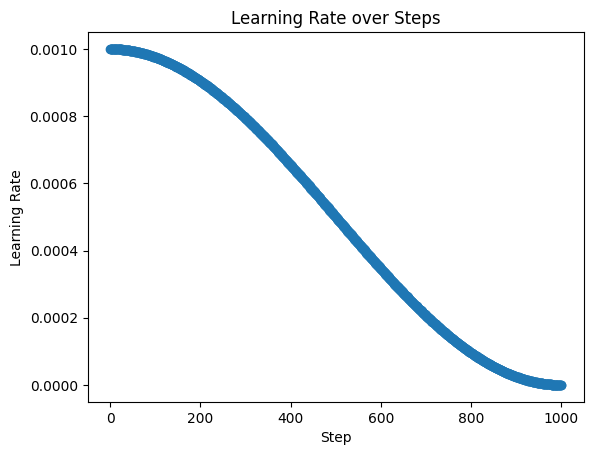

In [ ]:
num_steps = 1000

scheduler = optax.cosine_decay_schedule(
  init_value=0.001,
  decay_steps=num_steps,  # How long to decay over.
)
learning_rates = [scheduler(i) for i in range(num_steps)]

plt.scatter(range(num_steps), learning_rates)
plt.title("Learning Rate over Steps")
plt.ylabel("Learning Rate")
plt.xlabel("Step");

In [ ]:
from dlfb.dna.model import TrainStateWithBatchNorm

In [ ]:
class ConvModelV2(nn.Module):
  """CNN with batch norm and dropout for binary classification."""

  conv_filters: int = 64  # Number of filters for conv layers.
  kernel_size: tuple[int] = (10,)  # Kernel size for 1D conv layers.
  dense_units: int = 128  # Units in first dense fully-connected layer.
  dropout_rate: float = 0.2  # Proportion of dense neurons to randomly drop out.

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    # First convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Second convolutional layer.
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(x, window_shape=(2,), strides=(2,))

    # Flatten the values before passing them to the dense layers.
    x = x.reshape((x.shape[0], -1))

    # First dense layer.
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    # Second dense layer.
    x = nn.Dense(self.dense_units // 2)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    # Output layer (single unit for binary classification).
    return nn.Dense(1)(x)

  def create_train_state(self, rng: jax.Array, dummy_input, tx):
    """Initializes model parameters and returns a train state for training."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input)
    state = TrainStateWithBatchNorm.create(
      apply_fn=self.apply,
      tx=tx,
      params=variables["params"],
      batch_stats=variables["batch_stats"],   # this part is for batch normalization
      key=rng_dropout,                        # this part is for dropout
    )
    return state

For now, we have all the pieces needed to create the training state

In [ ]:
rng = jax.random.PRNGKey(42)
rng, rng_init, rng_train = jax.random.split(rng, 3)
state = ConvModelV2().create_train_state(
  rng=rng_init, dummy_input=batch["sequences"], tx=optax.adam(scheduler)
)

In [ ]:
@jax.jit
def train_step(state, batch, rng_dropout: jax.Array):
  """Run a training step and update parameters."""

  def calculate_loss(params, batch):
    """Make predictions on batch and compute binary cross-entropy loss."""
    logits, updates = state.apply_fn(
      {"params": params, "batch_stats": state.batch_stats},
      x=batch["sequences"],
      is_training=True,
      rngs={"dropout": rng_dropout},
      mutable=["batch_stats"],   # Tells apply that we expect the model to return the "batch_stats" collection.
    )

    loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()

    return loss, updates

  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (loss, updates), grads = grad_fn(state.params, batch)
  state = state.apply_gradients(grads=grads)
  # With mutable=["batch_stats"] you typically get something like updates = {"batch_stats": { ... new running mean/var ... }}
  state = state.replace(batch_stats=updates["batch_stats"]) # creates a new TrainState instance

  metrics = {"loss": loss}

  return state, metrics

In [ ]:
# Overfit on one batch.
for i in range(6):
  rng_train, rng_dropout = jax.random.split(rng_train, 2) #Split rng into a new rng (master) and rng_dropout (for this step)
  state, metrics = train_step(state, batch, rng_dropout)
  print(f"Step {i} loss: {metrics['loss']}")

Step 0 loss: 0.7316564321517944
Step 1 loss: 0.4482097625732422
Step 2 loss: 0.35601988434791565
Step 3 loss: 0.1291758269071579
Step 4 loss: 0.06689172983169556
Step 5 loss: 0.06967668235301971


Looks good—the loss decreases quickly. This indicates the model is capable of fitting the data.

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
def eval_step(state, batch):
  """Evaluate model on a single batch."""
  logits = state.apply_fn(
    {"params": state.params, "batch_stats": state.batch_stats},
    x=batch["sequences"],
    is_training=False,
    mutable=False,
  )
  loss = optax.sigmoid_binary_cross_entropy(logits, batch["labels"]).mean()
  metrics = {
    "loss": loss.item(),
    **compute_metrics(batch["labels"], logits),
  }
  return metrics


def compute_metrics(y_true: np.ndarray, logits: np.ndarray):
  """Compute accuracy and auROC for model predictions."""
  metrics = {
    "accuracy": accuracy_score(y_true, nn.sigmoid(logits) >= 0.5),
    "auc": roc_auc_score(y_true, logits),
  }
  return metrics

Note that since `scikit-learn` functions are not JAX compatible, the evaluation step is not decorated with `@jax.jit`

In [ ]:
# Evaluate the batch.
metrics = eval_step(state, batch)
print(metrics)

{'loss': 0.42622804641723633, 'accuracy': 1.0, 'auc': 1.0}


Now that we’ve implemented the training and evaluation steps, let’s define a full training loop.

The train function takes an initialized model state, training and validation datasets, and a few configuration parameters

In [ ]:
from dlfb.utils.metrics_logger import MetricsLogger
from dlfb.utils.restore import restorable

In [ ]:
@restorable
def train(
  state: TrainStateWithBatchNorm,
  rng: jax.Array,
  dataset_splits: dict[str, tf.data.Dataset],
  num_steps: int,
  eval_every: int = 100,
) :
  """Train a model and log metrics over steps."""
  metrics = MetricsLogger()
  train_batches = dataset_splits["train"].as_numpy_iterator()

  steps = tqdm(range(num_steps))  # Steps with progress bar.
  for step in steps:
    steps.set_description(f"Step {step + 1}")

    rng, rng_dropout = jax.random.split(rng, 2)
    train_batch = next(train_batches)
    state, batch_metrics = train_step(state, train_batch, rng_dropout)
    metrics.log_step(split="train", **batch_metrics)

    if step % eval_every == 0:
      for eval_batch in dataset_splits["valid"].as_numpy_iterator():
        batch_metrics = eval_step(state, eval_batch)
        metrics.log_step(split="valid", **batch_metrics)
      metrics.flush(step=step)

    steps.set_postfix_str(metrics.latest(["loss"]))

  return state, metrics.export()

Since we’re training one model per TF, we’ll use a utility function to load datasets split by TF name

In [ ]:
def load_dataset_splits(
  path, transcription_factor, batch_size: int | None = None
):
  """Load TF dataset splits (train, valid, test) as TensorFlow datasets."""
  dataset_splits = {}
  for split in ["train", "valid", "test"]:
    dataset = load_dataset(
      sequence_db=f"{path}/{transcription_factor}_{split}_sequences.csv"
    )
    ds = convert_to_tfds(dataset, batch_size, is_training=(split == "train"))
    dataset_splits.update({split: ds})
  return dataset_splits

We now have everything in place to train one model per TF

In [ ]:
prefix = assets("dna/datasets")
tf_metrics = {}

# Train one model per transcription factor.
for transcription_factor in transcription_factors:
  # Load data for this TF.
  dataset_splits = load_dataset_splits(
    assets("dna/datasets"), transcription_factor, batch_size
  )
  rng = jax.random.PRNGKey(42)
  rng, rng_init, rng_train = jax.random.split(rng, 3)
  dummy_batch = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

  # Create train state.
  state = ConvModelV2().create_train_state(
    rng=rng_init,
    dummy_input=dummy_batch,
    tx=optax.adam(scheduler),
  )

  # Train the model.
  _, metrics = train(
    state=state,
    rng=rng_train,
    dataset_splits=dataset_splits,
    num_steps=num_steps,
    eval_every=100,
    store_path=assets(f"dna/models/{transcription_factor}"),
  )

  # Store metrics.
  tf_metrics.update({transcription_factor: metrics})

AttributeError: 'str' object has no attribute 'data'

In [ ]:
from dlfb.dna.inspect import plot_learning

tf = "CTCF"
plot_learning(tf_metrics[tf], tf);

# Advanced Techniques

Before we introduce more complex model components, let’s first improve the clarity and modularity of our model architecture by refactoring it into reusable building blocks. This makes our code easier to read, extend, and maintain.

We will modularize our convolutional and MLP layers by creating two helper modules, `ConvBlock` and `MLPBlock`

In [ ]:
class ConvBlock(nn.Module):
  """Convolutional block with batch norm, GELU and max pooling."""

  conv_filters: int
  kernel_size: tuple[int]
  pool_size: int

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    x = nn.Conv(
      features=self.conv_filters, kernel_size=self.kernel_size, padding="SAME"
    )(x)
    x = nn.BatchNorm(use_running_average=not is_training)(x)
    x = nn.gelu(x)
    x = nn.max_pool(
      x, window_shape=(self.pool_size,), strides=(self.pool_size,)
    )
    return x


class MLPBlock(nn.Module):
  """Dense + GELU + dropout block."""

  dense_units: int
  dropout_rate: float = 0.0

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    return x

In [ ]:
class ConvTransformerModel(nn.Module):
  """Model combining CNN, transformer, and MLP blocks."""

  num_conv_blocks: int = 2
  conv_filters: int = 64
  kernel_size: tuple[int] = (10,)
  num_mlp_blocks: int = 2
  dense_units: int = 128
  dropout_rate: float = 0.2  # Global.
  num_transformer_blocks: int = 0
  num_transformer_heads: int = 8
  transformer_dense_units: int = 64

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    for _ in range(self.num_conv_blocks):
      x = ConvBlock(
        conv_filters=self.conv_filters,
        kernel_size=self.kernel_size,
        pool_size=2,
      )(x, is_training)

    for i in range(self.num_transformer_blocks):
      x = TransformerBlock(
        num_heads=self.num_transformer_heads,
        dense_units=self.transformer_dense_units,
        dropout_rate=self.dropout_rate,
      )(x, is_training)

    x = x.reshape((x.shape[0], -1))

    for i in range(self.num_mlp_blocks):
      x = MLPBlock(
        dense_units=self.dense_units // (i + 1), dropout_rate=self.dropout_rate
      )(x, is_training)

    return nn.Dense(1)(x)

In [ ]:
class TransformerBlock(nn.Module):
  """Transformer block with self-attention and MLP."""

  num_heads: int = 8
  dense_units: int = 64
  dropout_rate: float = 0.2

  @nn.compact
  def __call__(self, x, is_training: bool = True):
    # Self-attention with layer norm.
    residual = x
    x = nn.LayerNorm()(x)
    x = nn.SelfAttention(num_heads=self.num_heads)(x)
    x += residual

    # Feedforward block.
    residual = x
    x = nn.LayerNorm()(x)
    x = nn.Dense(self.dense_units)(x)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)
    x = nn.Dense(self.dense_units)(x)  # No GELU after this Dense.
    x += residual
    return x

- **Layer normalization:**
Transformers typically use layer norm rather than batch norm, as it tends to be more stable for sequence-based models and is invariant to batch size.

- **Position information:** In our current setup, we omit explicit positional encodings—this is a simplification that may be acceptable for short sequences (e.g., 200 bp), where the relative arrangement of motifs can still be learned through the convolutional layers preceding attention. For longer inputs or if attention is applied very early, consider adding learned or sinusoidal positional encodings.

## Defining Various Model Architectures

In [ ]:
models = {
  # Our standard 2-layer CNN with dropout and MLP.
  "baseline": ConvTransformerModel(),
  # Ablations: Remove or reduce certain components.
  # Only a single convolutional block.
  "single_conv_only": ConvTransformerModel(
    num_conv_blocks=1, num_transformer_blocks=0, num_mlp_blocks=0
  ),
  # Reduced capacity by lowering conv filters.
  "fewer_conv_channels": ConvTransformerModel(conv_filters=8),
  # Drop the MLP layers to test if they help.
  "remove_MLP": ConvTransformerModel(num_mlp_blocks=0),
  # Potential improvements: Add more expressive capacity.
  # Add a transformer block after convolutions.
  "add_one_transformer_block": ConvTransformerModel(num_transformer_blocks=1),
  # Stack two transformer blocks.
  "add_two_transformer_block": ConvTransformerModel(num_transformer_blocks=2),
}

To test these variants, we’ll focus on the most difficult TF from our earlier results: ZNF24, which achieved a peak validation auROC of 0.76 in our initial model. This makes it a great candidate to explore whether architectural improvements can lead to better predictive performance.

## Sweeping Over the Different Models

In [ ]:
# Train and evaluate multiple model architectures on the ZNF24 dataset.
transcription_factor = "ZNF24"
dataset_splits = load_dataset_splits(
    assets("dna/datasets"), transcription_factor, batch_size
  )

# # Prepare a dummy input for model initialization.
# dummy_input = next(dataset_splits["train"].as_numpy_iterator())["sequences"]

# # Initialize PRNGs.
# rng = jax.random.PRNGKey(42)
# rng, rng_init, rng_train = jax.random.split(rng, 3)

# # Dictionary to store metrics for each model variant.
# model_metrics = {}

# # Train each model variant and store its metrics.
# for name, model in models.items():
#   state = model.create_train_state(
#     rng=rng_init,
#     dummy_input=dummy_input,
#     tx=optax.adamw(
#       optax.cosine_decay_schedule(
#         init_value=learning_rate,
#         decay_steps=num_steps,
#       )
#     ),
#   )
#   _, metrics = train(
#     state=state,
#     rng=rng_train,
#     dataset_splits=dataset_splits,
#     num_steps=num_steps,
#     eval_every=100,
#     store_path=assets(f"dna/models/{name}"),
#   )
#   model_metrics.update({name: metrics})

AttributeError: 'str' object has no attribute 'data'